# Exercise 3.7

## 미로 그리기

적당히 복잡해 보이는 미로를 예쁘게 그려 봅니다.

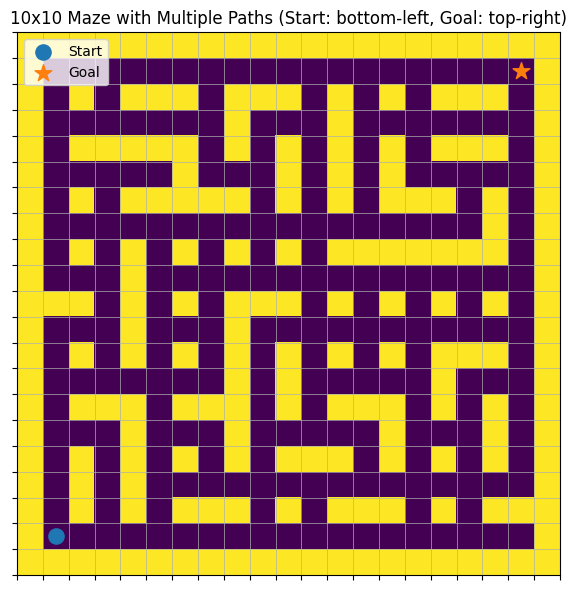

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

# 10x10 Maze with multiple distinct paths (loops added)
# 전제: numpy as np, random, matplotlib.pyplot as plt 가 이미 import됨

H, W = 10, 10  # 셀 격자 크기
DIRS = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # 위, 오른쪽, 아래, 왼쪽

def in_bounds(r, c):
    return 0 <= r < H and 0 <= c < W

def generate_maze_with_loops(loop_prob=0.25):
    """
    1) DFS로 perfect maze(스패닝 트리) 생성
    2) 인접 셀 사이 임의의 벽을 확률적으로 허물어 루프를 추가
    3) (2H+1) x (2W+1) 격자(1=벽, 0=길)로 변환
    """
    # 1) DFS로 스패닝 트리 생성
    visited = np.zeros((H, W), dtype=bool)
    adj = [[[] for _ in range(W)] for __ in range(H)]

    stack = [(H-1, 0)]  # 시작: 좌하단
    visited[H-1, 0] = True

    while stack:
        r, c = stack[-1]
        # 미방문 이웃 셔플
        nbrs = []
        for dr, dc in DIRS:
            nr, nc = r + dr, c + dc
            if in_bounds(nr, nc) and not visited[nr, nc]:
                nbrs.append((nr, nc))
        random.shuffle(nbrs)

        if not nbrs:
            stack.pop()
            continue

        nr, nc = nbrs[0]
        visited[nr, nc] = True
        adj[r][c].append((nr, nc))
        adj[nr][nc].append((r, c))
        stack.append((nr, nc))

    # 2) 루프 추가: 인접 셀인데 아직 연결되지 않은 경우, 확률적으로 벽을 허문다
    #    연결 정보는 adj에 저장되어 있으므로, 없으면 추가
    for r in range(H):
        for c in range(W):
            for dr, dc in DIRS:
                nr, nc = r + dr, c + dc
                if not in_bounds(nr, nc):
                    continue
                # 아직 연결되어 있지 않은 인접 쌍만 고려
                if (nr, nc) not in adj[r][c]:
                    if random.random() < loop_prob:
                        adj[r][c].append((nr, nc))
                        adj[nr][nc].append((r, c))

    # 3) (2H+1)x(2W+1) 격자로 변환: 1=벽, 0=길
    grid = np.ones((2*H + 1, 2*W + 1), dtype=int)
    for r in range(H):
        for c in range(W):
            gr, gc = 2*r + 1, 2*c + 1
            grid[gr, gc] = 0  # 셀 중심은 길
            for nr, nc in adj[r][c]:
                ngr, ngc = 2*nr + 1, 2*nc + 1
                grid[(gr + ngr)//2, (gc + ngc)//2] = 0  # 통로

    return grid

# 미로 생성: 루프 확률(loop_prob)을 조정하면 경로 다양성이 달라집니다.
maze_grid = generate_maze_with_loops(loop_prob=0.30)

# 시작점과 목표점 좌표(셀 좌표 기준)
start_cell = (H-1, 0)   # bottom-left
goal_cell  = (0,  W-1)  # top-right

# 시작점/목표점 픽셀 좌표(벽/길 격자 기준)
start_px = (2*start_cell[0] + 1, 2*start_cell[1] + 1)
goal_px  = (2*goal_cell[0]  + 1, 2*goal_cell[1]  + 1)

# 시각화
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(maze_grid, origin="upper", interpolation="nearest")
ax.set_title("10x10 Maze with Multiple Paths (Start: bottom-left, Goal: top-right)")
ax.set_xticks(np.arange(-0.5, maze_grid.shape[1], 1))
ax.set_yticks(np.arange(-0.5, maze_grid.shape[0], 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(which="both", linewidth=0.5)

# 시작/목표 표기
ax.scatter([start_px[1]], [start_px[0]], marker="o", s=120, label="Start")
ax.scatter([goal_px[1]],  [goal_px[0]],  marker="*", s=160, label="Goal")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Q-learning

Q-learning 을 사용할 거예요. 아직 Q-learning 을 배우지 않았으니, 자세한 리워드 업데이트 방법은 아직 살펴보지 않아도 돼요. 

Step penalty 를 줄 때(음수 값)와 주지 않을 때(STEP_PENALTY = 0)의 차이를 살펴봅시다. 

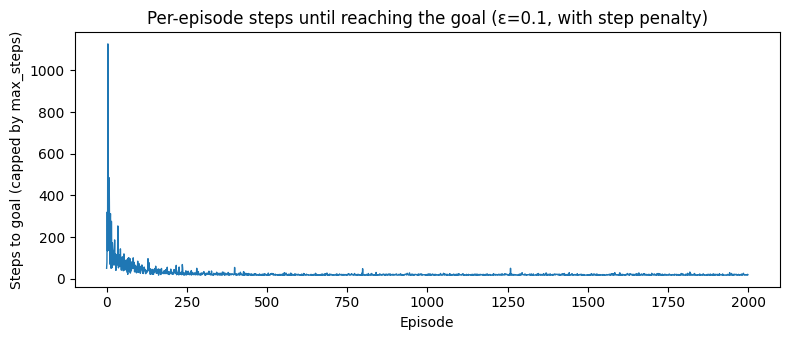

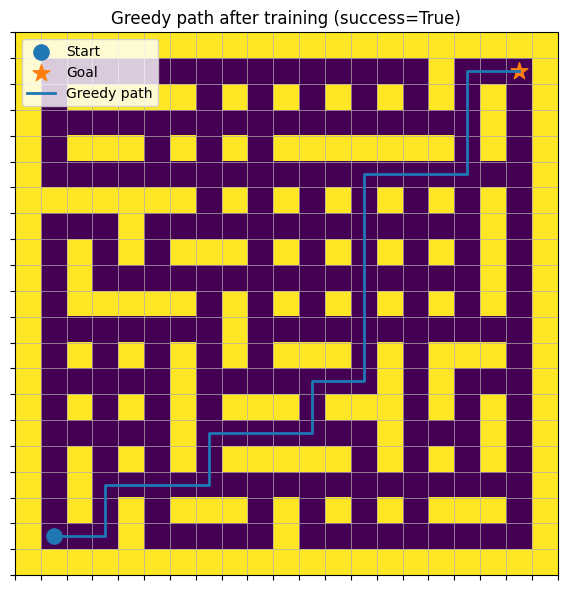

In [ ]:
# ===== Q-learning with step penalty (reward shaping) =====
import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

EPSILON = 0.1  # 고정 epsilon
STEP_PENALTY = 0  # 매 이동마다 패널티

# 셀 (r,c) ↔ (nr,nc) 사이가 열려 있는지 확인
def corridor_open(r, c, nr, nc):
    pr, pc = 2*r + 1, 2*c + 1
    qr, qc = 2*nr + 1, 2*nc + 1
    wr, wc = (pr + qr)//2, (pc + qc)//2
    return maze_grid[wr, wc] == 0

@dataclass
class MazeEnvPenalty:
    H: int
    W: int
    start: Tuple[int, int]
    goal: Tuple[int, int]
    max_steps: int = 1500

    def reset(self):
        self.state = self.start
        self.steps = 0
        return self.state

    def step(self, action: int):
        r, c = self.state
        if action == 0: nr, nc = r-1, c
        elif action == 1: nr, nc = r, c+1
        elif action == 2: nr, nc = r+1, c
        else: nr, nc = r, c-1

        if not (0 <= nr < self.H and 0 <= nc < self.W) or not corridor_open(r, c, nr, nc):
            nr, nc = r, c  # 벽이거나 영역 밖이면 제자리

        self.state = (nr, nc)
        self.steps += 1

        if self.state == self.goal:
            reward = 1.0
        else:
            reward = STEP_PENALTY

        done = (self.state == self.goal) or (self.steps >= self.max_steps)
        return self.state, reward, done

class QAgentPenalty:
    def __init__(self, env: MazeEnvPenalty, alpha=0.2, gamma=0.99):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.Q = np.zeros((env.H, env.W, 4), dtype=float)

    def select_action(self, s):
        if random.random() < EPSILON:
            return random.randint(0, 3)
        r, c = s
        return int(np.argmax(self.Q[r, c]))

    def learn_episode(self):
        s = self.env.reset()
        done = False
        while not done:
            a = self.select_action(s)
            s_next, r, done = self.env.step(a)
            r0, c0 = s
            r1, c1 = s_next
            td_target = r + (0 if done else self.gamma * np.max(self.Q[r1, c1]))
            self.Q[r0, c0, a] += self.alpha * (td_target - self.Q[r0, c0, a])
            s = s_next
        return self.env.steps, (s == self.env.goal)

# ----- 학습 실행 -----
env_pen = MazeEnvPenalty(H=H, W=W, start=start_cell, goal=goal_cell, max_steps=1500)
agent_pen = QAgentPenalty(env_pen, alpha=0.2, gamma=0.99)

episodes = 2000
steps_per_episode = []
for ep in range(1, episodes+1):
    steps, ok = agent_pen.learn_episode()
    steps_per_episode.append(steps)

# 에피소드별 Goal 도달까지 이동 횟수 시각화
plt.figure(figsize=(8, 3.5))
plt.plot(steps_per_episode, linewidth=1)
plt.xlabel("Episode")
plt.ylabel("Steps to goal (capped by max_steps)")
plt.title("Per-episode steps until reaching the goal (ε=0.1, with step penalty)")
plt.tight_layout()
plt.show()

# ----- 학습 후 그리디 경로 확인 -----
def greedy_path_pen(max_steps=3000):
    s = env_pen.reset()
    path = [s]
    for _ in range(max_steps):
        r, c = s
        a = int(np.argmax(agent_pen.Q[r, c]))
        s_next, _, done = env_pen.step(a)
        path.append(s_next)
        s = s_next
        if done:
            break
    return path, (s == env_pen.goal)

path, ok = greedy_path_pen()
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(maze_grid, origin="upper", interpolation="nearest")
ax.set_xticks(np.arange(-0.5, maze_grid.shape[1], 1))
ax.set_yticks(np.arange(-0.5, maze_grid.shape[0], 1))
ax.set_xticklabels([]); ax.set_yticklabels([])
ax.grid(which="both", linewidth=0.5)
ax.scatter([2*start_cell[1]+1], [2*start_cell[0]+1], marker="o", s=120, label="Start")
ax.scatter([2*goal_cell[1]+1],  [2*goal_cell[0]+1],  marker="*", s=160, label="Goal")
ys = [2*r+1 for r, c in path]
xs = [2*c+1 for r, c in path]
ax.plot(xs, ys, linewidth=2, label="Greedy path")
ax.legend(loc="upper left")
ax.set_title(f"Greedy path after training (success={ok})")
plt.tight_layout()
plt.show()

## MDP

MDP는 결정론적인 방법이기 때문에 Exercise 3.7에서 말하고자 하는 바를 직관적으로 보이기 조금 어렵습니다. 그래도 해 볼 수 있습니다. 대신 /gamma를 1로 설정합니다. 

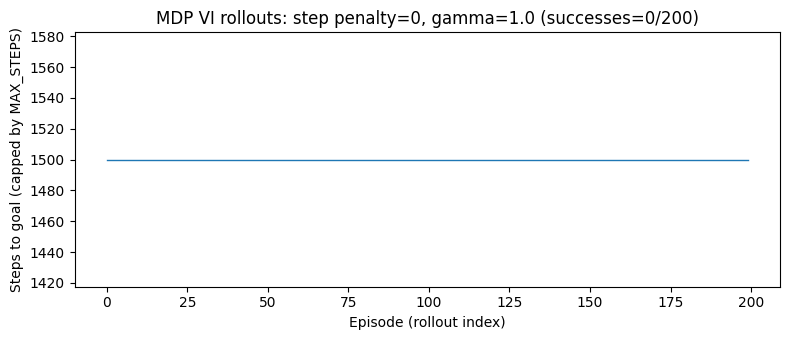

목표에 도달하지 못했습니다. (정책이 루프에 갇힘)


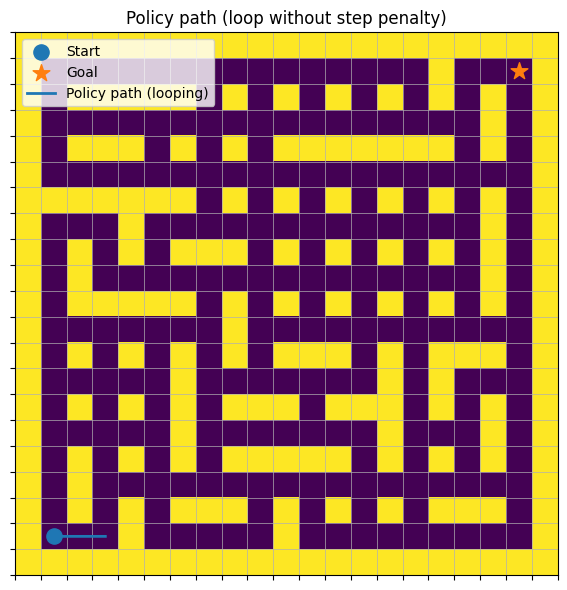

In [37]:
# ===== MDP (Value Iteration) with step penalty = 0, goal reward = +1, gamma = 1.0 =====

STEP_PENALTY = 0.0    # 이동 패널티 없음
GOAL_REWARD  = 1.0    # 목표 도달 보상
GAMMA        = 1.0    # 할인 없음 -> 경로 길이에 무관하게 도달만 하면 동일 가치
THETA        = 1e-8   # 수렴 임계값
MAX_ITERS    = 20000  # 가치 반복 최대 반복 수
MAX_STEPS    = 1500   # 롤아웃 최대 스텝

# 셀 (r,c) ↔ (nr,nc) 사이 통로 여부
def corridor_open(r, c, nr, nc):
    pr, pc = 2*r + 1, 2*c + 1
    qr, qc = 2*nr + 1, 2*nc + 1
    wr, wc = (pr + qr)//2, (pc + qc)//2
    return maze_grid[wr, wc] == 0

# 결정론적 전이
# action: 0=up, 1=right, 2=down, 3=left
def step_det(state, action):
    r, c = state
    if action == 0: nr, nc = r-1, c
    elif action == 1: nr, nc = r, c+1
    elif action == 2: nr, nc = r+1, c
    else: nr, nc = r, c-1
    if not (0 <= nr < H and 0 <= nc < W) or not corridor_open(r, c, nr, nc):
        nr, nc = r, c  # 막혀 있으면 제자리
    return (nr, nc)

# 보상 함수
def reward_fn(s, a, s_next):
    return GOAL_REWARD if s_next == goal_cell else STEP_PENALTY

# 가치 반복
V  = np.zeros((H, W), dtype=float)
pi = np.zeros((H, W), dtype=int)

# 동률일 때 루프를 유발하기 쉬운 행동 순서를 의도적으로 고정
# 예: 우선순위 [오른쪽, 아래, 왼쪽, 위] -> 환경 구조에 따라 동일가치 구간에서 순환 가능
ACTION_ORDER = [1, 2, 3, 0]

for it in range(MAX_ITERS):
    delta = 0.0
    for r in range(H):
        for c in range(W):
            s = (r, c)
            if s == goal_cell:
                # 목표 상태는 종료 상태로 간주(여기서는 V를 0에 고정)
                continue
            best_val = -1e30
            best_a = ACTION_ORDER[0]
            for a in ACTION_ORDER:
                s_next = step_det(s, a)
                rwd = reward_fn(s, a, s_next)
                next_val = 0.0 if s_next == goal_cell else V[s_next]
                qsa = rwd + GAMMA * next_val
                if qsa > best_val:
                    best_val = qsa
                    best_a = a
            delta = max(delta, abs(best_val - V[s]))
            V[s] = best_val
            pi[s] = best_a
    if delta < THETA:
        break

# 정책 롤아웃
def rollout(policy, max_steps=MAX_STEPS):
    s = start_cell
    steps = 0
    path = [s]
    while steps < max_steps and s != goal_cell:
        a = int(policy[s])
        s = step_det(s, a)
        steps += 1
        path.append(s)
    return steps, (s == goal_cell), path

episodes = 200
steps_per_episode = []
succ = 0
first_success_path = None

for _ in range(episodes):
    steps, ok, path = rollout(pi, MAX_STEPS)
    steps_per_episode.append(steps)
    succ += int(ok)
    if ok and first_success_path is None:
        first_success_path = path

# 결과 시각화: 에피소드별 목표까지 스텝 수
plt.figure(figsize=(8, 3.5))
plt.plot(steps_per_episode, linewidth=1)
plt.xlabel("Episode (rollout index)")
plt.ylabel("Steps to goal (capped by MAX_STEPS)")
plt.title(f"MDP VI rollouts: step penalty=0, gamma=1.0 (successes={succ}/{episodes})")
plt.tight_layout()
plt.show()

# 성공 경로가 없으면(=그래프가 MAX_STEPS의 평행선) 루프에 갇힌 정책 예시를 표기
if first_success_path is None:
    print("목표에 도달하지 못했습니다. (정책이 루프에 갇힘)")
    # 루프를 시각화: 임의 한 번의 롤아웃 경로를 그림
    _, _, path = rollout(pi, MAX_STEPS)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(maze_grid, origin="upper", interpolation="nearest")
    ax.set_xticks(np.arange(-0.5, maze_grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, maze_grid.shape[0], 1))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.grid(which="both", linewidth=0.5)
    ax.scatter([2*start_cell[1]+1], [2*start_cell[0]+1], marker="o", s=120, label="Start")
    ax.scatter([2*goal_cell[1]+1],  [2*goal_cell[0]+1],  marker="*", s=160, label="Goal")
    ys = [2*r+1 for r, c in path]
    xs = [2*c+1 for r, c in path]
    ax.plot(xs, ys, linewidth=2, label="Policy path (looping)")
    ax.legend(loc="upper left")
    ax.set_title("Policy path (loop without step penalty)")
    plt.tight_layout()
    plt.show()
else:
    # 성공 경로가 나온 경우(드물게 tie-break이 탈출을 선택) 시각화
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(maze_grid, origin="upper", interpolation="nearest")
    ax.set_xticks(np.arange(-0.5, maze_grid.shape[1], 1))
    ax.set_yticks(np.arange(-0.5, maze_grid.shape[0], 1))
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.grid(which="both", linewidth=0.5)
    ax.scatter([2*start_cell[1]+1], [2*start_cell[0]+1], marker="o", s=120, label="Start")
    ax.scatter([2*goal_cell[1]+1],  [2*goal_cell[0]+1],  marker="*", s=160, label="Goal")
    ys = [2*r+1 for r, c in first_success_path]
    xs = [2*c+1 for r, c in first_success_path]
    ax.plot(xs, ys, linewidth=2, label="Path (no step penalty)")
    ax.legend(loc="upper left")
    ax.set_title("Path with no step penalty (gamma=1.0)")
    plt.tight_layout()
    plt.show()

# Exercise 4.1

The following code is an example given by the Professor. If you use a generative AI, you can get better code. 

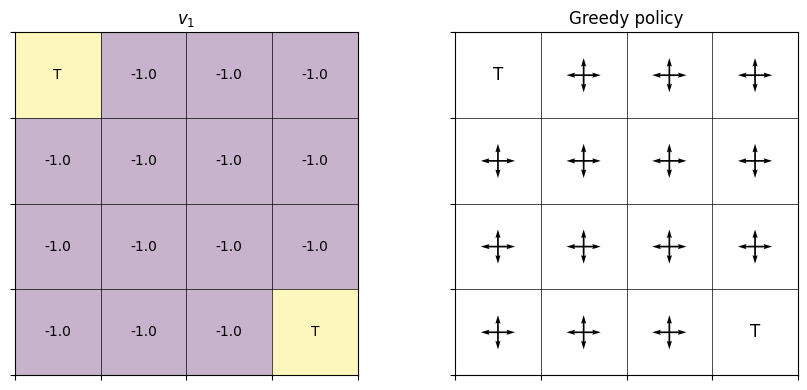

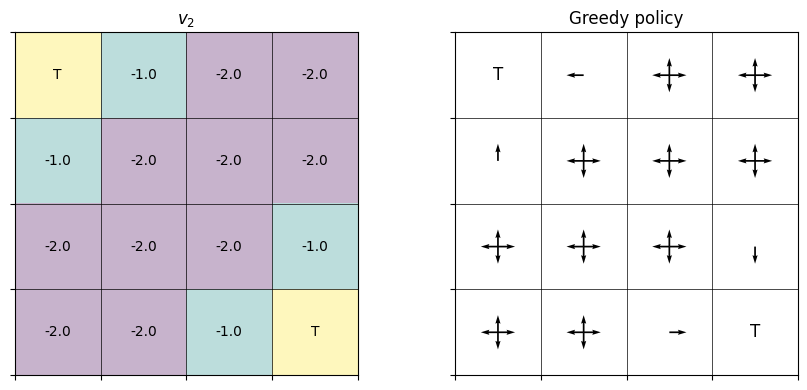

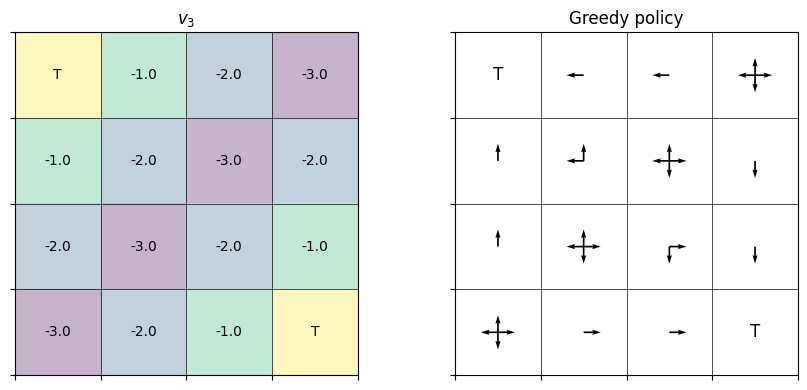

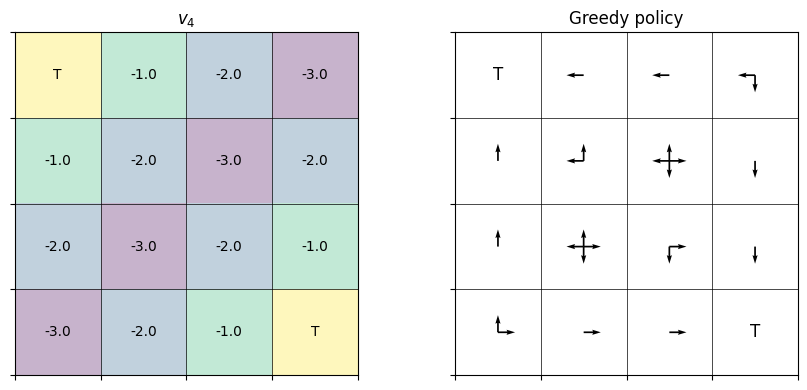

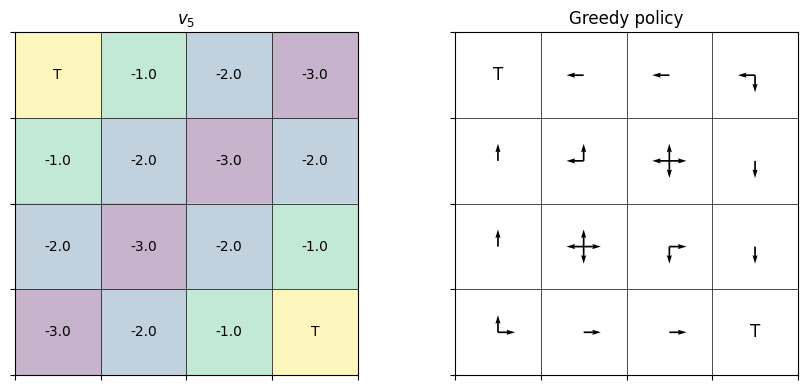

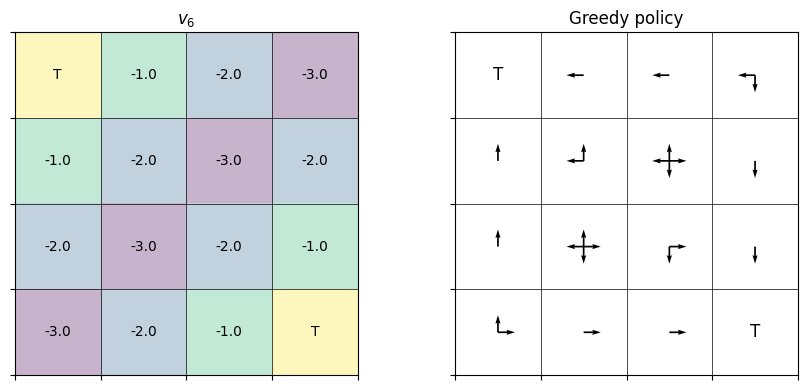

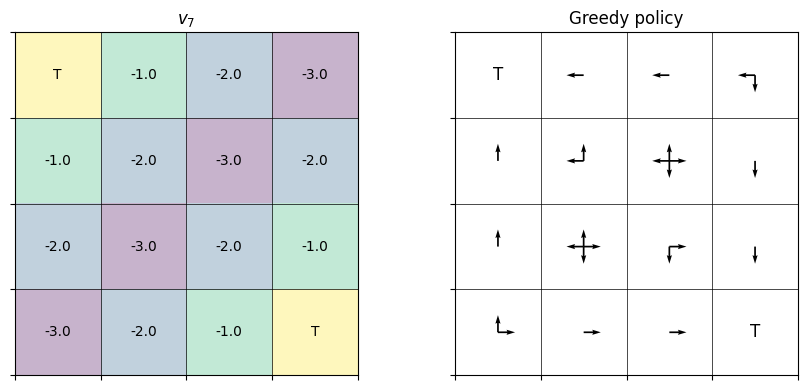

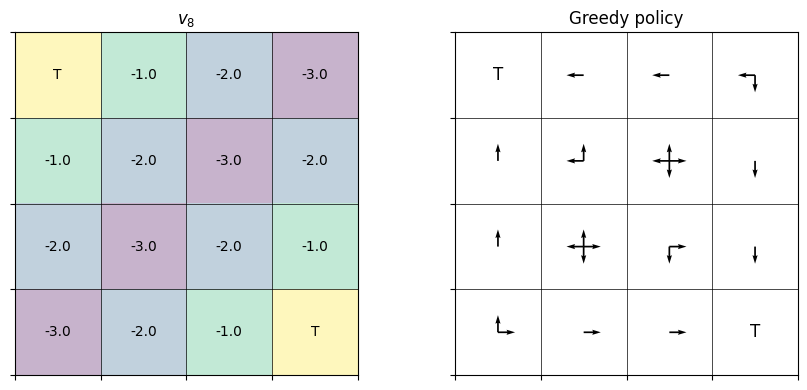

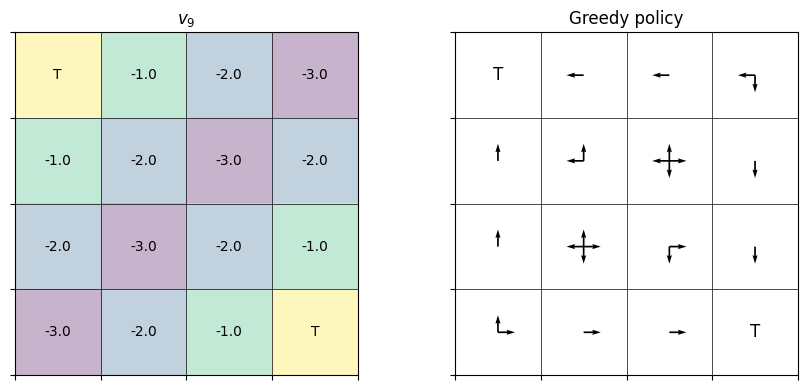

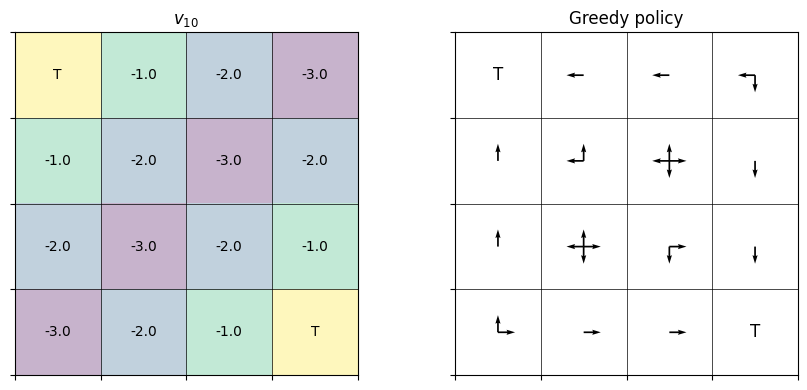

In [9]:
# Example 4.1: 4x4 Gridworld, Policy Iteration with per-sweep snapshots v_k and policy arrows
import numpy as np
import matplotlib.pyplot as plt

# ----- Problem setup -----
H, W = 4, 4
states = [(r, c) for r in range(H) for c in range(W)]
terminal_positions = {(0, 0), (H-1, W-1)}  # shaded terminals; formally a single terminal, both treated as terminal cells
ACTIONS = ['up', 'right', 'down', 'left']
A2DELTA = {'up': (-1, 0), 'right': (0, 1), 'down': (1, 0), 'left': (0, -1)}

def in_bounds(r, c):
    return 0 <= r < H and 0 <= c < W

def step(state, action):
    """Deterministic transition; off-grid => unchanged. Reward = -1 until terminal reached."""
    r, c = state
    if state in terminal_positions:
        return state, 0  # no cost once already terminal; v(terminal)=0
    dr, dc = A2DELTA[action]
    nr, nc = r + dr, c + dc
    if not in_bounds(nr, nc):
        nr, nc = r, c
    reward = -1
    return (nr, nc), reward

# indices for mapping (r,c) <-> s
idx = {(r, c): r*W + c for r, c in states}
pos = {idx[p]: p for p in states}

# ----- 1) Initialize -----
V = np.zeros(H * W, dtype=float)  # state values
# start with equiprobable random policy (π(a|s)=1/4 for nonterminal, 0 for terminal)
pi = {s: {a: (0.0 if pos[s] in terminal_positions else 0.25) for a in ACTIONS} for s in range(H*W)}

def policy_evaluation_one_sweep(V, pi):
    """One synchronous sweep: V_new(s) = sum_a π(a|s)[ r + V(s') ] with r=-1 per step, terminal V=0."""
    V_new = V.copy()
    for s in range(H*W):
        r, c = pos[s]
        if (r, c) in terminal_positions:
            V_new[s] = 0.0
            continue
        val = 0.0
        for a, p_a in pi[s].items():
            if p_a == 0.0:
                continue
            (nr, nc), rwd = step((r, c), a)
            s_next = idx[(nr, nc)]
            val += p_a * (rwd + V[s_next])
        V_new[s] = val
    return V_new

def greedy_policy_from_V(V):
    """π'(s) = argmax_a q(s,a) where q(s,a) = -1 + V(s') (or 0 at terminal). Break ties by Up,Right,Down,Left."""
    new_pi = {}
    for s in range(H*W):
        r, c = pos[s]
        if (r, c) in terminal_positions:
            new_pi[s] = {a: 0.0 for a in ACTIONS}
            continue
        # compute q(s,a)
        q_vals = []
        for a in ACTIONS:
            (nr, nc), rwd = step((r, c), a)
            s_next = idx[(nr, nc)]
            q_vals.append((-1 + V[s_next]))  # rwd is -1 for nonterminal moves; consistent with step()
        # tie-break in order Up, Right, Down, Left
        best_idx = np.flatnonzero(q_vals == np.max(q_vals))
        preferred = np.zeros(len(ACTIONS), dtype=float)
        for k in best_idx:
            preferred[k] = 1.0
        preferred /= preferred.sum()
        new_pi[s] = {a: preferred[i] for i, a in enumerate(ACTIONS)}
    return new_pi

def arrows_from_policy(pi):
    """Return a grid of arrow directions for plotting."""
    # map actions to unit vectors for quiver: x points right, y points up (matplotlib)
    a2vec = {'up': (0, 1), 'right': (1, 0), 'down': (0, -1), 'left': (-1, 0)}
    U = np.zeros((H, W))  # x-components
    Vv = np.zeros((H, W)) # y-components
    for s in range(H*W):
        r, c = pos[s]
        if (r, c) in terminal_positions:
            continue
        # if deterministic greedy, mass sits on some actions; otherwise use expected direction
        dx = dy = 0.0
        for a, p_a in pi[s].items():
            if p_a > 0:
                vx, vy = a2vec[a]
                dx += p_a * vx
                dy += p_a * vy
        U[r, c] = dx
        Vv[r, c] = dy
    return U, Vv

def draw_vk_and_policy(V, pi, k):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4))
    # Left: v_k values
    axL = axes[0]
    grid_vals = V.reshape(H, W)
    #axL.imshow(grid_vals, origin='upper', interpolation='nearest')
    axL.imshow(grid_vals, origin='upper', interpolation='nearest', cmap='viridis', alpha=0.30)

    for r in range(H):
        for c in range(W):
            txt = "T" if (r, c) in terminal_positions else f"{grid_vals[r, c]:.1f}"
            axL.text(c, r, txt, ha='center', va='center')
    axL.set_xticks(np.arange(-0.5, W, 1))
    axL.set_yticks(np.arange(-0.5, H, 1))
    axL.set_xticklabels([])
    axL.set_yticklabels([])
    axL.grid(color='k', linewidth=0.5)
    axL.set_title(f"$v_{{{k}}}$")

    # Right: policy arrows (greedy policy at iteration k)
    axR = axes[1]
    #axR.imshow(np.zeros((H, W)), origin='upper', interpolation='nearest')
    axR.imshow(np.zeros((H, W)), origin='upper', interpolation='nearest', cmap='Greys', vmin=0, vmax=1)
    a2vec = {'up': (0, 1), 'right': (1, 0), 'down': (0, -1), 'left': (-1, 0)}
    for s in range(H*W):
        r, c = pos[s]
        if (r, c) in terminal_positions:
            continue
        for a, p_a in pi[s].items():
            if p_a > 0.0:
                dx, dy = a2vec[a]
                axR.quiver(
                    c, r, dx, -dy,
                    angles='xy',
                    scale_units='xy',
                    scale=5,     # 숫자를 크게 할수록 화살표가 짧아짐 (예: 5~8 추천)
                    width=0.005  # 화살표 선 두께를 줄임
            )
    # mark terminals
    for (tr, tc) in terminal_positions:
        axR.text(tc, tr, "T", ha='center', va='center', fontsize=12)
    axR.set_xticks(np.arange(-0.5, W, 1))
    axR.set_yticks(np.arange(-0.5, H, 1))
    axR.set_xticklabels([])
    axR.set_yticklabels([])
    axR.grid(color='k', linewidth=0.5)
    axR.set_title("Greedy policy")

    plt.tight_layout()
    plt.show()

# ----- Iterations k = 1..10 -----
for k in range(1, 11):
    # 2) Policy Evaluation (one synchronous sweep to produce v_k)
    V = policy_evaluation_one_sweep(V, pi)
    draw_vk_and_policy(V, pi, k)   # 현재 정책으로 그림(개선 전이므로 첫 회는 4방향 모두 표시)
    pi = greedy_policy_from_V(V)

# Example 4.2: Jack’s Car Rental 

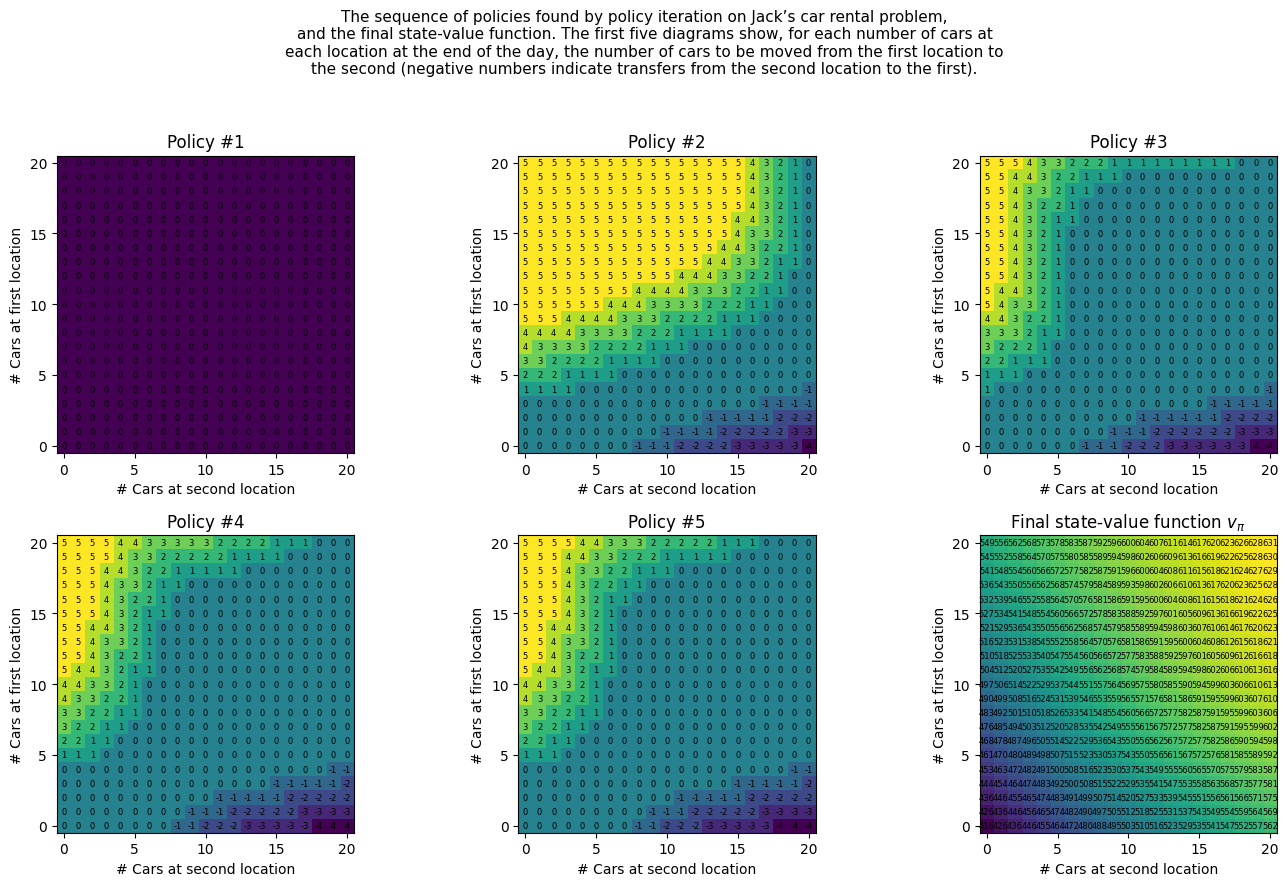

In [10]:
# Jack's Car Rental (Example 4.2) — Policy Iteration
# Figure: sequence of policies (first five) and final state-value function
# Axes: y = #Cars at first location, x = #Cars at second location

import numpy as np
import matplotlib.pyplot as plt
from math import exp

# -------------------------------
# Problem parameters
# -------------------------------
MAX_CARS   = 20
MAX_MOVE   = 5
RENT_REWARD = 10
MOVE_COST   = 2
GAMMA       = 0.9

# Poisson means: requests (λ_r1=3, λ_r2=4), returns (λ_ret1=3, λ_ret2=2)
REQ_LAM_1, REQ_LAM_2 = 3, 4
RET_LAM_1, RET_LAM_2 = 3, 2

# Truncation for Poisson sums (tail beyond this n is negligible in expectation)
POISSON_MAX = 11  # increase for higher accuracy (runtime ↑)

# -------------------------------
# Utilities
# -------------------------------
def poisson_probs(lam, n_max=POISSON_MAX):
    """Precompute Poisson pmf p(n; lam) for n=0..n_max."""
    # Stable recurrence: p(0)=e^{-λ}, p(n)=p(n-1)*λ/n
    p = np.zeros(n_max + 1, dtype=float)
    p[0] = exp(-lam)
    for n in range(1, n_max + 1):
        p[n] = p[n-1] * lam / n
    # (We ignore leftover tail mass beyond n_max; increase n_max to reduce bias)
    return p

P_REQ_1 = poisson_probs(REQ_LAM_1, POISSON_MAX)
P_REQ_2 = poisson_probs(REQ_LAM_2, POISSON_MAX)
P_RET_1 = poisson_probs(RET_LAM_1, POISSON_MAX)
P_RET_2 = poisson_probs(RET_LAM_2, POISSON_MAX)

def feasible_actions(s1, s2):
    """Feasible overnight moves a: cars moved from loc1 -> loc2.
       Respect inventory and capacity limits."""
    low  = -min(MAX_MOVE, s2)           # moving from 2 -> 1
    high =  min(MAX_MOVE, s1)           # moving from 1 -> 2
    # Also cannot exceed capacity after move
    low  = max(low,  -(MAX_CARS - s1))  # ensure s1+a <= MAX_CARS
    high = min(high,   MAX_CARS - s2)   # ensure s2-a <= MAX_CARS -> a >= s2 - MAX_CARS
    return range(low, high + 1)

def expected_return(s1, s2, a, V):
    """Compute expected one-day return for state (s1,s2) taking action a, under equiprobable request/return dynamics."""
    # Overnight move
    s1_ov = min(MAX_CARS, max(0, s1 - a))
    s2_ov = min(MAX_CARS, max(0, s2 + a))
    reward_move = -MOVE_COST * abs(a)

    G = 0.0
    # Requests at both locations
    for req1, p_r1 in enumerate(P_REQ_1):
        # rentals limited by availability
        rent1 = min(s1_ov, req1)
        rem1_after_rent = s1_ov - rent1

        for req2, p_r2 in enumerate(P_REQ_2):
            rent2 = min(s2_ov, req2)
            rem2_after_rent = s2_ov - rent2

            prob_req = p_r1 * p_r2
            reward_rental = RENT_REWARD * (rent1 + rent2)

            # Returns at both locations
            # (Cars returned “today” become available for tomorrow.)
            subtotal = 0.0
            for ret1, p_ret1 in enumerate(P_RET_1):
                s1_next = min(MAX_CARS, rem1_after_rent + ret1)
                for ret2, p_ret2 in enumerate(P_RET_2):
                    s2_next = min(MAX_CARS, rem2_after_rent + ret2)
                    prob = prob_req * p_ret1 * p_ret2
                    subtotal += prob * (reward_move + reward_rental + GAMMA * V[s1_next, s2_next])

            G += subtotal
    return G

# -------------------------------
# 1. Initialization
# -------------------------------
V = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=float)
# Policy π(s1,s2) = number of cars moved from loc1 to loc2 (start with “never move”)
PI = np.zeros_like(V, dtype=int)

# Storage for first five policy snapshots
policy_snapshots = []

# -------------------------------
# Policy Iteration
# -------------------------------
THETA = 1e-3  # evaluation tolerance
max_policy_plots = 5

iteration = 0
while True:
    iteration += 1

    # -------------------------------
    # 2. Policy Evaluation
    # -------------------------------
    while True:
        delta = 0.0
        V_new = V.copy()
        for s1 in range(MAX_CARS + 1):
            for s2 in range(MAX_CARS + 1):
                a = PI[s1, s2]
                V_new[s1, s2] = expected_return(s1, s2, a, V)
        delta = np.abs(V_new - V).max()
        V = V_new
        if delta < THETA:
            break

    # Save current policy snapshot (up to five)
    if len(policy_snapshots) < max_policy_plots:
        policy_snapshots.append(PI.copy())

    # -------------------------------
    # 3. Policy Improvement
    # -------------------------------
    policy_stable = True
    for s1 in range(MAX_CARS + 1):
        for s2 in range(MAX_CARS + 1):
            old_a = PI[s1, s2]
            # Greedy w.r.t. V over feasible actions
            best_val = -1e18
            best_a = 0
            for a in feasible_actions(s1, s2):
                val = expected_return(s1, s2, a, V)
                if val > best_val:
                    best_val = val
                    best_a = a
            PI[s1, s2] = best_a
            if best_a != old_a:
                policy_stable = False

    if policy_stable:
        # Add final policy if we have collected fewer than five snapshots
        if len(policy_snapshots) < max_policy_plots:
            policy_snapshots.append(PI.copy())
        break

# -------------------------------
# Plotting:
#   2D policies (first five) and final value function
#   y-axis: #Cars at first location, x-axis: #Cars at second location
# -------------------------------
n_policies = min(len(policy_snapshots), 5)
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

for i in range(n_policies):
    ax = axes[i]
    im = ax.imshow(policy_snapshots[i], origin='lower', interpolation='nearest')
    # overlay integers for clarity
    for y in range(MAX_CARS + 1):
        for x in range(MAX_CARS + 1):
            ax.text(x, y, f"{policy_snapshots[i][y, x]:d}", ha='center', va='center', fontsize=6)
    ax.set_title(f"Policy #{i+1}")
    ax.set_xlabel("# Cars at second location")
    ax.set_ylabel("# Cars at first location")
    ax.set_xticks([0, 5, 10, 15, 20])
    ax.set_yticks([0, 5, 10, 15, 20])

# Final state-value function
axV = axes[-1]
imV = axV.imshow(V, origin='lower', interpolation='nearest')
for y in range(MAX_CARS + 1):
    for x in range(MAX_CARS + 1):
        axV.text(x, y, f"{V[y, x]:.0f}", ha='center', va='center', fontsize=6)
axV.set_title("Final state-value function $v_\\pi$")
axV.set_xlabel("# Cars at second location")
axV.set_ylabel("# Cars at first location")
axV.set_xticks([0, 5, 10, 15, 20])
axV.set_yticks([0, 5, 10, 15, 20])

fig.suptitle(
    "The sequence of policies found by policy iteration on Jack’s car rental problem,\n"
    "and the final state-value function. The first five diagrams show, for each number of cars at\n"
    "each location at the end of the day, the number of cars to be moved from the first location to\n"
    "the second (negative numbers indicate transfers from the second location to the first).",
    y=0.98, fontsize=11
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Example 4.3: Gambler’s Problem

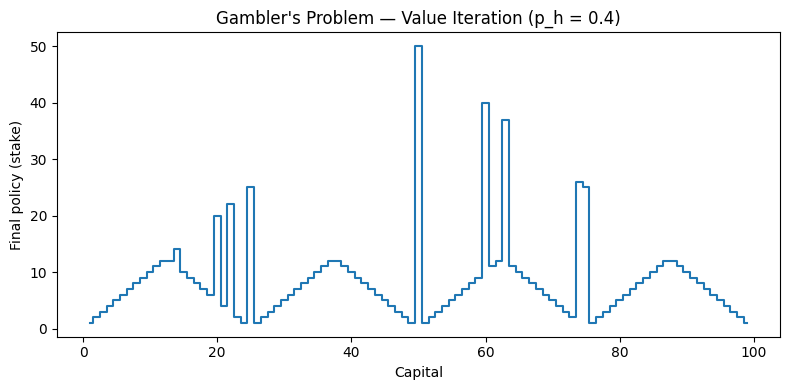

In [7]:
# Gambler's Problem (Example 4.3) solved by Value Iteration (Sutton & Barto, 2e)
# p_h = probability of heads. Plot: x = Capital (1..99), y = Final policy (stake).

import numpy as np
import matplotlib.pyplot as plt

# ----- Problem setup -----
p_h = 0.4              # probability of heads
goal = 100
states = np.arange(0, goal + 1)  # 0..100
gamma = 1.0            # undiscounted episodic
theta = 1e-9           # small threshold for value iteration convergence

# Reward: +1 only on transitions that land at state=100, else 0.
# Terminal states: 0 and 100.

# ----- 1) Initialization -----
V = np.zeros(goal + 1, dtype=float)  # V(0)=V(100)=0

def stakes_for_state(s):
    """Feasible stakes a at capital s: 1..min(s, goal-s)."""
    if s <= 0 or s >= goal:
        return []
    return range(1, min(s, goal - s) + 1)

def q_value(s, a, V):
    """
    q(s,a) = p_h * [r(s->s+a) + gamma * V(s+a)] + (1-p_h) * [r(s->s-a) + gamma * V(s-a)]
    r = 1 if s+a == goal else 0
    """
    win_state = s + a
    lose_state = s - a
    r_win = 1.0 if win_state == goal else 0.0
    r_lose = 0.0  # no reward on loss
    return p_h * (r_win + gamma * V[win_state]) + (1.0 - p_h) * (r_lose + gamma * V[lose_state])

# ----- 2) Value Iteration (Algorithm 4.4 in the book) -----
while True:
    delta = 0.0
    V_old = V.copy()
    for s in range(1, goal):  # skip terminals
        actions = list(stakes_for_state(s))
        if not actions:
            continue
        # Bellman optimality backup for v_*(s)
        q_vals = [q_value(s, a, V_old) for a in actions]
        V[s] = max(q_vals)
        delta = max(delta, abs(V[s] - V_old[s]))
    if delta < theta:
        break

# ----- 3) Extract optimal policy (greedy w.r.t. converged V) -----
pi_star = np.zeros(goal + 1, dtype=int)
for s in range(1, goal):
    actions = list(stakes_for_state(s))
    if not actions:
        pi_star[s] = 0
        continue
    q_vals = [q_value(s, a, V) for a in actions]
    # Tie-breaking: choose the first max (S&B plots may show multiple optimal stakes at some p_h)
    best_idx = int(np.argmax(q_vals))
    pi_star[s] = actions[best_idx]

# ----- Plot: Capital (x) vs Final policy/stake (y) -----
capitals = np.arange(1, goal)  # 1..99
stakes = pi_star[1:goal]

plt.figure(figsize=(8, 4))
plt.step(capitals, stakes, where='mid')
plt.xlabel("Capital")
plt.ylabel("Final policy (stake)")
plt.title(f"Gambler's Problem — Value Iteration (p_h = {p_h})")
plt.tight_layout()
plt.show()